In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pid_model as pidmodel
import PID_Performances as pidper

## Pid controller with $\theta_{ref} = 0.78$

In [2]:
sp = np.zeros(300) + 0.78
theta_store, omega_store, sp_store, v_store,step, ts = pidmodel.run(299, 300, sp, [0.0,0.0], False, 15,30,30)

In [3]:
pidper.print_performances(theta_store, sp_store, ts)

overshoot: 0.072
rise time: 4.0
steady state error: 0.0
settling time: 15.0


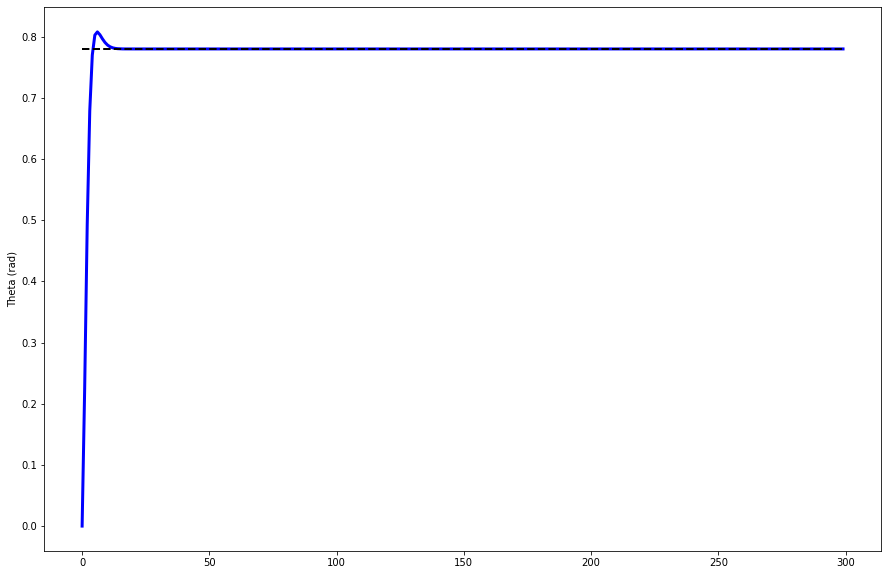

In [4]:
pidmodel.plot(theta_store, omega_store, sp_store, v_store,step, ts)

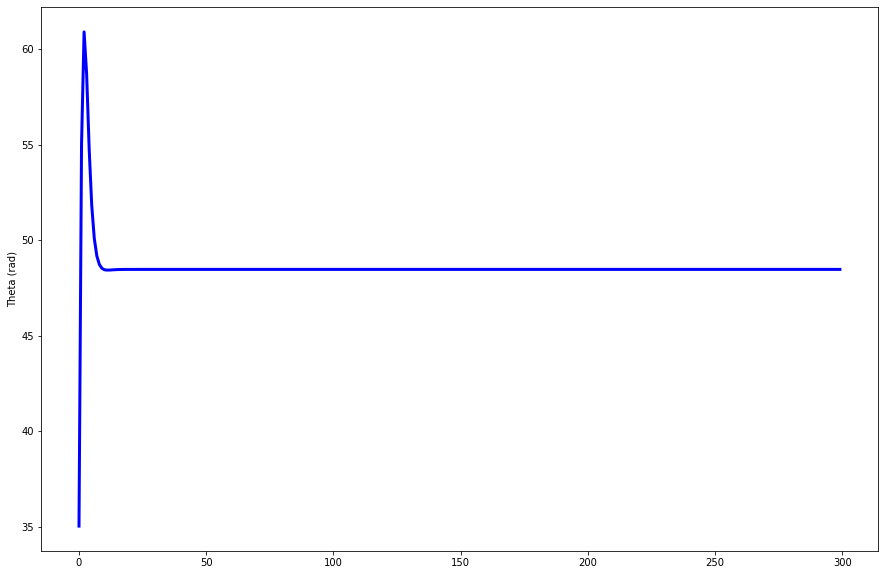

In [5]:
plt.plot(ts,step,'b-',linewidth=3)
plt.ylabel('Theta (rad)')
plt.show()

## Pid controller with sinusoidal reference signal

In [6]:
sp = [np.sin(i/20)/10 + 0.2 for i in range(300)]
theta_store, omega_store, sp_store, v_store,step, ts = pidmodel.run(299, 300, sp, [0.0,0.0], True, 15,30,30)

In [7]:
print(f'overshoot: {pidper.overshoot(theta_store, sp_store)}')
print(f'rise time: {pidper.rise_time(theta_store, sp_store, ts)}')
print(f'steady state error: {pidper.steady_state_error(theta_store, sp_store)}')
print(f'settling time: {pidper.settling_time(theta_store, ts)}')

overshoot: 0.019
rise time: 4.013
steady state error: 0.01
settling time: 14.047


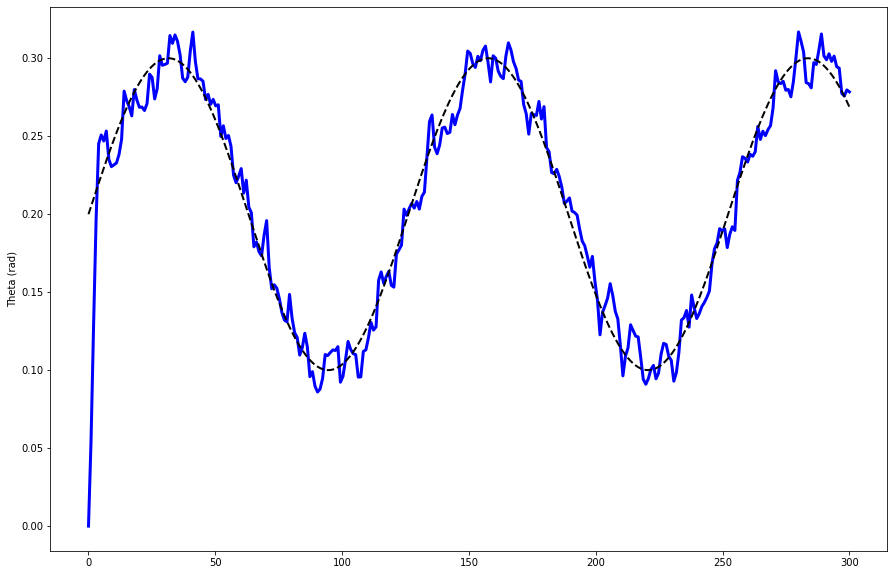

In [8]:
pidmodel.plot(theta_store, omega_store, sp_store, v_store,step, ts)

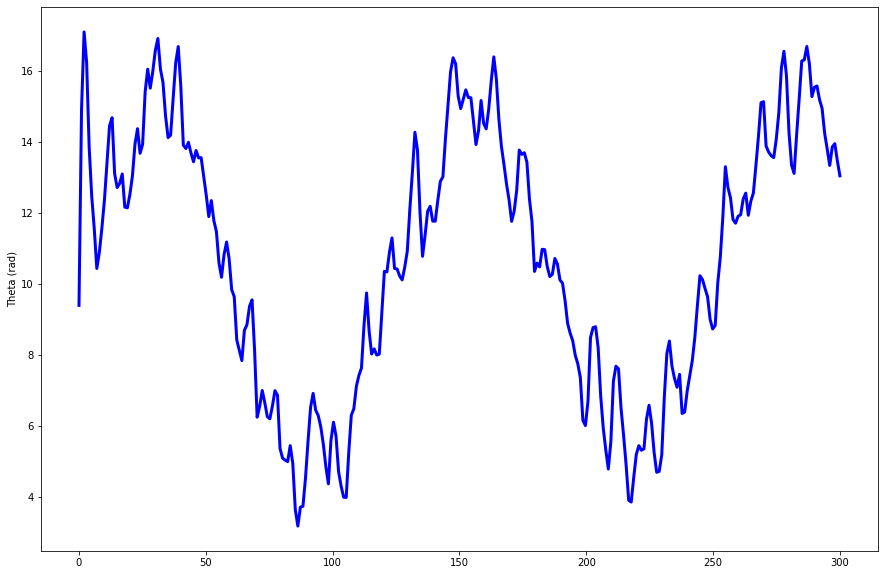

In [9]:
plt.plot(ts,step,'b-',linewidth=3)
plt.ylabel('Theta (rad)')
plt.show()

## Requirements in STL with Moonlight

In [8]:
from moonlight import *

In [11]:
script = """
signal { real x; }
domain boolean; 
formula min_oscillation = {eventually [0.0, 10.0] {globally (x > 1.0)}};
"""

moonlightScript = ScriptLoader.loadFromText(script)

[[  0.  -1.]
 [289.  -1.]]


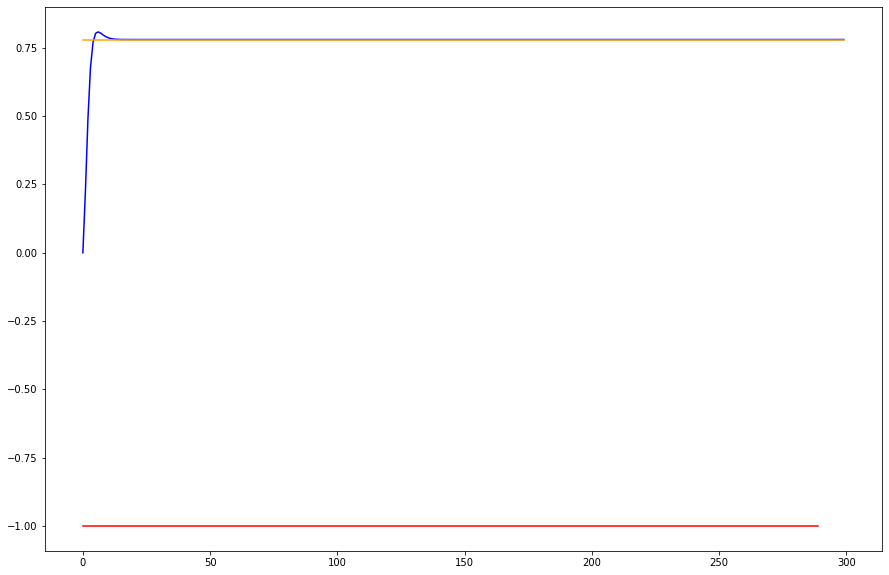

In [12]:
futureMonitor = moonlightScript.getMonitor("min_oscillation");

ts_temp = list(ts)
signals = list(zip(theta_store))
result = futureMonitor.monitor(ts_temp,signals)
arrayresults = np.array(futureMonitor.monitor(ts_temp,signals))

plt.rcParams["figure.figsize"] = (15,10)
plt.plot(ts_temp,theta_store, color="blue")
plt.plot(ts_temp,sp_store, color="orange")
#plt.plot(ts_temp,(step > 0), color="yellow")
plt.step(arrayresults[:,0],arrayresults[:,1], color="red")
print(arrayresults)

In [11]:
# Formula phi_2 = Once the reference angle is reached the oscillations of the observed angle are minimal

# formula min_oscillation = eventually {globally ((x < 0.05) & (x > (-0.05)))};

# formula min_oscillation = eventually {globally ((x > (y - 0.001)) & (x < (y + 0.001)))};


#globally [0.0, 299.0] (x < 0.008);
#{eventually {globally [300.0, 900.0] (p < 1.0)}}

script = """
signal { real x; }
domain boolean; 
formula min_oscillation = {eventually [0.0,5.0] {globally (x < 0.000001)}};
"""

moonlightScript = ScriptLoader.loadFromText(script)

[[  0.  -1.]
 [ 19.   1.]
 [294.   1.]]


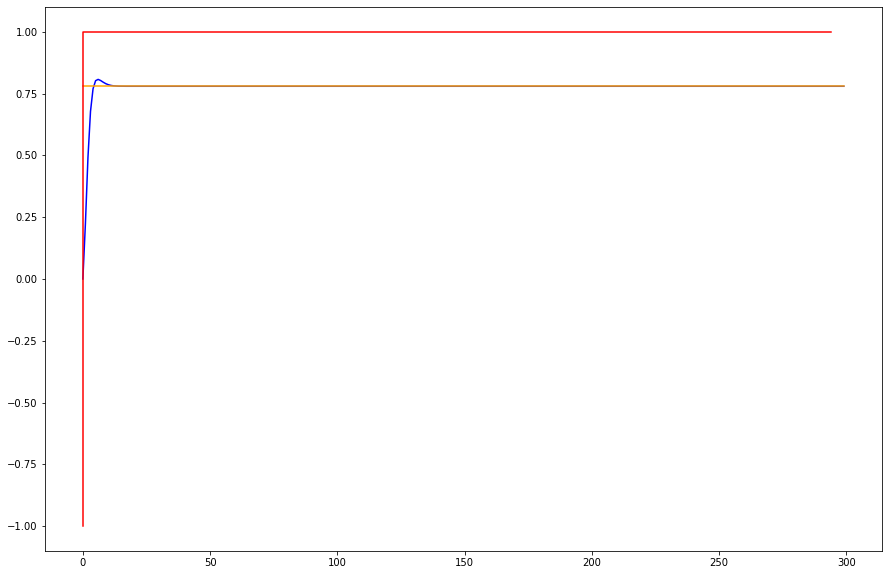

In [12]:
futureMonitor = moonlightScript.getMonitor("min_oscillation");

# Monitor the signal
ts_temp = list(ts)
x_vals = abs(theta_store - sp_store)
signals = list(zip(x_vals))
result = futureMonitor.monitor(ts_temp,signals)
arrayresults = np.array(futureMonitor.monitor(ts_temp,signals))

plt.rcParams["figure.figsize"] = (15,10)
plt.plot(ts_temp,theta_store, color="blue")
plt.plot(ts_temp,sp_store, color="orange")
#plt.plot(ts_temp,(step > 0), color="yellow")
plt.step(arrayresults[:,0],arrayresults[:,1], color="red")
print(arrayresults)

In [40]:
# Formula phi_3 = the speed/acceleration change must be positive when the input angle is smaller than the target and viceversa

script = """
signal { real x; real y; real u;}
domain boolean; 
formula speed_change_according_theta = globally (((x < y) -> (u >= 0)) & ((x > y) -> (u < 0)));
"""

moonlightScript = ScriptLoader.loadFromText(script)

[[ 0. -1.]]


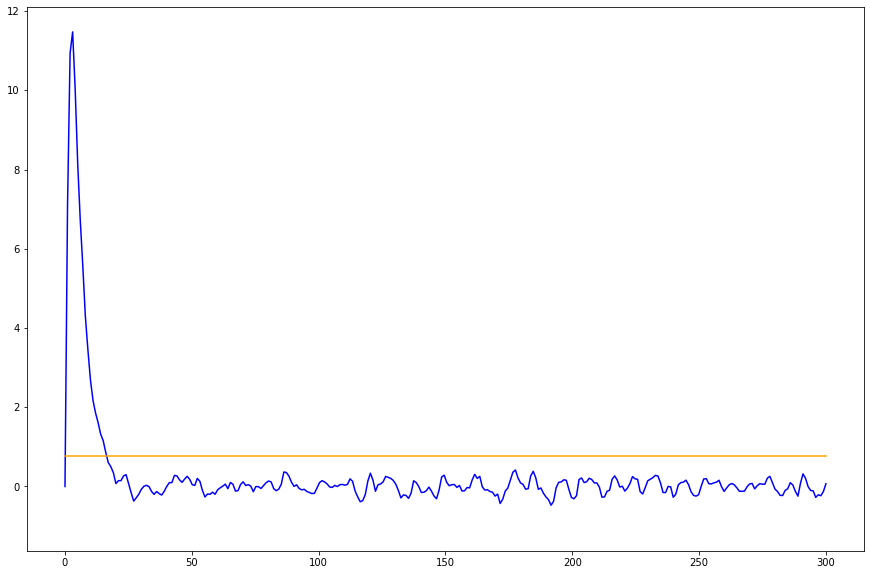

In [12]:
diff_v = np.zeros(len(v_store))
for i in range(1, len(v_store)):
    diff_v[i] = v_store[i] - v_store[i-1]

diff_v

futureMonitor = moonlightScript.getMonitor("speed_change_according_theta");
# Monitor the signal
ts_temp = list(ts) 
signals = list(zip(theta_store, sp_store, diff_v))
result = futureMonitor.monitor(ts_temp,signals)
arrayresults = np.array(futureMonitor.monitor(ts_temp,signals))

plt.rcParams["figure.figsize"] = (15,10)
plt.plot(ts_temp,diff_v, color="blue")
plt.plot(ts_temp,sp_store, color="orange")
#plt.plot(ts_temp,(step > 0), color="yellow")
plt.step(arrayresults[:,0],arrayresults[:,1], color="red")
print(arrayresults)

In [36]:
# We do not want to exceed the speed limit

script = """
signal { real x; }
domain boolean; 
formula speed_limit = globally (x < 130);
"""

moonlightScript = ScriptLoader.loadFromText(script)

[[  0.   1.]
 [300.   1.]]


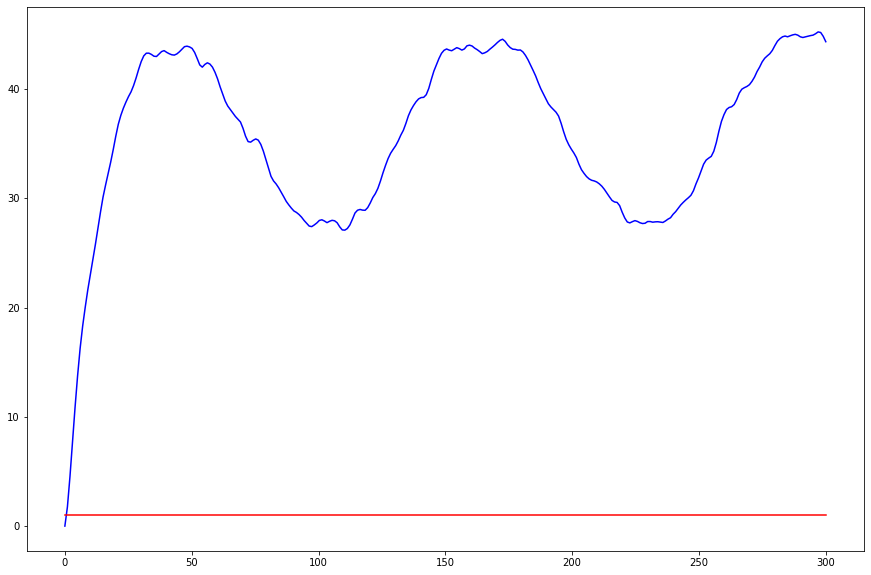

In [37]:
futureMonitor = moonlightScript.getMonitor("speed_limit");


# Monitor the signal
ts_temp = list(ts)
signals = list(zip(v_store))
result = futureMonitor.monitor(ts_temp,signals)
arrayresults = np.array(futureMonitor.monitor(ts_temp,signals))

plt.rcParams["figure.figsize"] = (15,10)
plt.plot(ts_temp,v_store, color="blue")
plt.step(arrayresults[:,0],arrayresults[:,1], color="red")
print(arrayresults)

In [13]:
mi, sigma = 0.0,.1
n = np.random.normal(mi,sigma, 100)

# L'idea è che aggiungo questo rumore all'osservazione dei sensori e controllo la robustness con o senza rumore
# RICORDA: formula verificata -> robustness > 0 